In [6]:
import os
import tensorflow as tf

# Set CUDA_VISIBLE_DEVICES for GPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# TensorFlow 2.x - Enable GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Import Keras modules
# from keras import layers, models, callbacks
# from keras.layers import Conv2D, BatchNormalization, Input, Activation, UpSampling2D, Lambda, Conv2DTranspose, add
# from keras.models import Model, load_model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, Activation, UpSampling2D, Lambda, Conv2DTranspose, add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K

# Additional libraries
from keras_tqdm import TQDMNotebookCallback  # Ensure this is installed
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Jupyter magic command (optional)
# try:
#     get_ipython().run_line_magic('matplotlib', 'inline')
# except NameError:
#     pass

# Define directories and parameters
params = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}
lr_img_dir = '/Users/manojkumar/image-super-resolution/data/lr_images/'
hr_img_dir = '/Users/manojkumar/image-super-resolution/data/hr_images/'
fnames = os.listdir('/Users/manojkumar/Downloads/mirflickr/')
lr_dims = (72, 72, 3)  # Number of channels is last dim with tf backend
hr_dims = (288, 288, 3)

# Proceed with your main code...


The CNN architechture used will be similar to ResNets.
- Has convolutional blocks.
- Has residual connections and hence need residual blocks.
- Upsampling would be done using de-convolution blocks.
(Instead of deconvolution block, we could use UpSampling2D from keras)

In [7]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Conv2D(filters, kernel_size=(size, size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [8]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return add([x, ip]) # Adding the transformed feature map with the original input (residual connection)

In [9]:
def deconv_block(x, filters, size, stride=(2,2)):
    x = Deconv2D(filters, kernel_size=(size, size), strides=stride, 
        padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [10]:
def up_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(filters, kernel_size=(size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [11]:
inp=Input(shape=lr_dims)
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3) # Try up-sampling vs. deconv instead (deconv might produce checkerboard patterns)
x=up_block(x, 64, 3)
x=Conv2D(3, kernel_size=(9, 9), activation='tanh', padding='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x) # +1 since tanh gives values between -1 and 1, and we need to scale to 0

Basically, our model takes a Low resolution 100x100 image, which is transformed through a series of conv blocks and residual connections. Then we start to up-sample/deconv the feature map to make it of size 400x400. 

Finally, we compare the 'content loss' between the generated image and the ground truth High resolution 400x400 image, when both are passed through some convolutional layer in Vgg16. In doing so, we are able to train a network that can upsample an image and recreate the higher resolution details.

In [12]:
base_model = Model(inputs=inp, outputs=outp)
base_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 72, 72, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 72, 72,    │     15,616 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 72, 72,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 72, 72,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 72, 72,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 72, 72,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 72, 72,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │     36,928 │ add_1[0][0]     

 Total params: 403,267 (1.54 MB)

 Trainable params: 401,859 (1.53 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:

import numpy as np
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
#standard mean pixel intensities for ImageNet and VGG16 Model for Normalization

preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [14]:
from PIL import Image
im = Image.open('/Users/manojkumar/image-super-resolution/data/hr_images/im10000.jpg')
img_arr = preproc(np.expand_dims(im, axis=0))
shp = img_arr.shape
shp

(1, 288, 288, 3)

In [15]:
from vgg16_avg import VGG16_Avg
vgg_inp=Input(shape=hr_dims)
vgg = VGG16_Avg(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [16]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 288, 288, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 288, 288, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 288, 288, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 288, 288, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (AveragePooling2D)  │ (None, 144, 144, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 144, 144, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 144, 144, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (AveragePooling2D)  │ (None, 72, 72, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 72, 72, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 72, 72, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 72, 72, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (AveragePooling2D)  │ (None, 36, 36, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 36, 36, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 36, 36, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 36, 36, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (AveragePooling2D)  │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (AveragePooling2D)  │ (None, 9, 9, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Since we only want to learn the "upsampling network" (base_model), and are just using VGG to calculate the loss function, we set the VGG layers to not be trainable.

In [17]:
for l in vgg.layers: l.trainable=False

In [18]:
# A function to return a model's output at a specified layer number (basically for VGG)
def get_outp(model, ln): 
    return model.get_layer(f'block{ln}_conv1').output

vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]]) # Layers 1,2,3

# Two VGG networks
# 1. One that takes the original ground truth HRes image as input
# 2. Second that takes the generated HRes image as input
vgg1 = vgg_content(Lambda(preproc)(vgg_inp))
vgg2 = vgg_content(Lambda(preproc)(outp))

In [19]:
# Calculate the MSE, and the ouput has shape (1, batch_size)
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, axis=dims)), axis=0)

# Test the above with numpy code
t = np.ones(shape=(8,200,200,3))
dims = list(range(1, np.ndim(t)))
K.eval(K.expand_dims(K.sqrt(K.mean(K.variable(t)**2, axis=dims)), axis=0)).shape

(1, 8)

In [20]:
w=[0.1, 0.8, 0.1] # Considering conv blocks 1,2,3 - different weights for each
def content_loss_fn(x): # x is an array of VGG1 outputs appended with an array of VGG2 outputs
    res = 0; n=len(w)
    for i in range(n): # Iterate through the 3 conv blocks
        # Below, we compare x[0] and x[3] | x[1] and x[4] and so on
        # x[0], x[1], x[2] are outputs of vgg1
        # x[3], x[4], x[5] are outputs of vgg2
        res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

We also define a zero vector as a target parameter, which is a **necessary parameter when calling fit on a keras model.**

In [21]:
model_sr = Model([inp, vgg_inp], Lambda(content_loss_fn)(vgg1+vgg2))# array of VGG1 outputs appended with an array of VGG2 outputs
targ = np.zeros(shape=list(hr_dims) + [1]) # From FastAI notebook
# targ = np.zeros(shape=(BATCH_SIZE,)) # This is used in my batch_generator function
# Target and input 1st dimensions should match

In [22]:
model_sr.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 72, 72, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 72, 72,    │     15,616 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 72, 72,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 72, 72,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 72, 72,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 72, 72,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 72, 72,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │     36,928 │ add_1[0][0]     

 Total params: 958,595 (3.66 MB)

 Trainable params: 401,859 (1.53 MB)

 Non-trainable params: 556,736 (2.12 MB)

#### Fit Generator and load data in batches

In [23]:
fnames = [f for f in fnames if f.endswith('jpg')]
len(fnames)

25000

In [24]:
train_files, _temp = train_test_split(fnames, test_size = 400)
dev_files, test_files = train_test_split(_temp, test_size = 0.5)

In [25]:
print(len(train_files))

24600


In [26]:
print(len(dev_files))

200


In [27]:
def load_batch(file_list):
    lr_img_array = []
    hr_img_array = []
    
    for file_ in file_list:
        lr_im = Image.open(lr_img_dir + file_)
        #lr_im = lr_im.resize((72, 72))
        lr_img_array.append(np.array(lr_im, dtype=np.uint8))
        
        hr_im = Image.open(hr_img_dir + file_)
        #hr_im = hr_im.resize((288, 288))
        hr_img_array.append(np.array(hr_im, dtype=np.uint8))
        
    return lr_img_array, hr_img_array

In [28]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            lr_img_array, hr_img_array = load_batch(file_list)
            #lr_img_array = np.array(lr_img_array)  # Convert to NumPy and set dtype
            #hr_img_array = np.array(hr_img_array)
            targ = np.zeros(shape=(BATCH_SIZE,), dtype=np.uint8)

            # lr_img_tensor = tf.convert_to_tensor(np.array(lr_img_array, dtype=tf.uint8))
            # hr_img_tensor = tf.convert_to_tensor(np.array(hr_img_array, dtype=tf.uint8))
            # target_tensor = tf.convert_to_tensor(targ, dtype=tf.uint8)

            # yield ([lr_img_tensor, hr_img_tensor], target_tensor)

            
            #yield [np.array(lr_img_array), np.array(hr_img_array)], targ # a tuple with two numpy arrays with batch_size samples     
            #yield ([lr_img_array, hr_img_array], targ)
            yield (np.array(lr_img_array, dtype=np.uint8), 
                np.array(hr_img_array, dtype=np.uint8)), targ
            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [29]:
BATCH_SIZE = 50
N_EPOCHS = 1
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(dev_files)//BATCH_SIZE

In [30]:
import tensorflow as tf

def get_tf_dataset(files, batch_size, lr_shape, hr_shape):
    dataset = tf.data.Dataset.from_generator(
        lambda: batch_generator(files, batch_size),
        output_signature=(
            (
                tf.TensorSpec(shape=(None,72,72,3 ), dtype=tf.uint8),  # Low-res input
                tf.TensorSpec(shape=(None, 288,288,3), dtype=tf.uint8),  # High-res input
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.uint8),  # Target
        )
    )
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [31]:
lr_shape = (72, 72, 3)  # Example shape for low-resolution images
hr_shape = (288, 288, 3)
train_dataset = get_tf_dataset(train_files, BATCH_SIZE, lr_shape, hr_shape)
val_dataset = get_tf_dataset(dev_files, BATCH_SIZE, lr_shape, hr_shape)

In [28]:
# The final layer returns losses as shape (1, batch_size) 
# - the loss is set to 'mae' to take mean average error across the batch
model_sr.compile(optimizer='adam', loss='mse') 
# model_sr.fit(x=[arr_lr, arr_hr], y=targ, batch_size=8, epochs=3)

history = model_sr.fit(x= train_dataset,
                                 epochs = N_EPOCHS,
                                 steps_per_epoch = STEPS_PER_EPOCH,
                                 validation_data = val_dataset, 
                                 validation_steps = VAL_STEPS,                                 
                                )

/Users/manojkumar/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_40']. Received: the structure of inputs=('*', '*')
  warnings.warn(


492/492 ━━━━━━━━━━━━━━━━━━━━ 80560s 164s/step - loss: 37534.2188 - val_loss: 21768.0078


In [30]:
#base_model.save_weights('/Users/manojkumar/image-super-resolution/saved_models/sr_upsampling_epoch_03_weights.h5')
base_model.save_weights('/Users/manojkumar/image-super-resolution/saved_models/sr_upsampling_epoch_03.weights.h5')


#### Performance Check
Test if the model produces high resolution images:

In [31]:
# custom_objects = {'rn_mean':rn_mean, 'w':w, 'mean_sqr_b': mean_sqr_b}
base_model.load_weights('/Users/manojkumar/image-super-resolution/saved_models/sr_upsampling_epoch_03.weights.h5')

In [32]:
# Make Prediction on Test set
lr_img_array_test = []

for file_ in test_files:
    lr_im = Image.open(lr_img_dir + file_)
    lr_img_array_test.append(np.array(lr_im))

In [33]:
p = base_model.predict(np.array(lr_img_array_test), batch_size=BATCH_SIZE)

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step


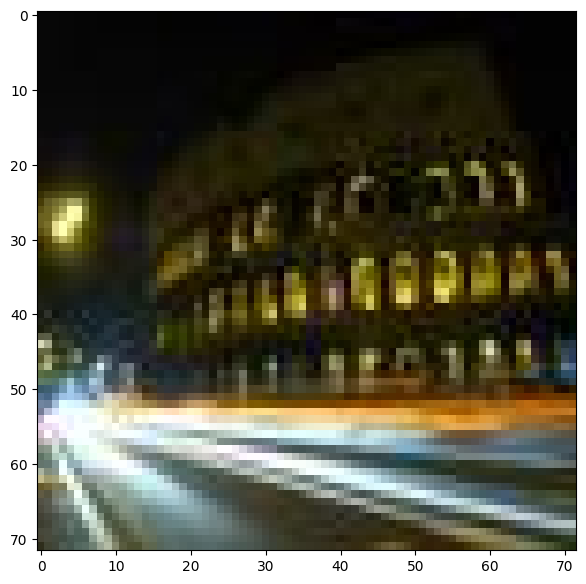

In [34]:
# Original LR image 72x72
k = 56
plt.figure(figsize=(7,7))
plt.imshow(lr_img_array_test[k])
# plt.imsave('images/results/upsampling/lr72x72.jpg', lr_img_array_test[k])

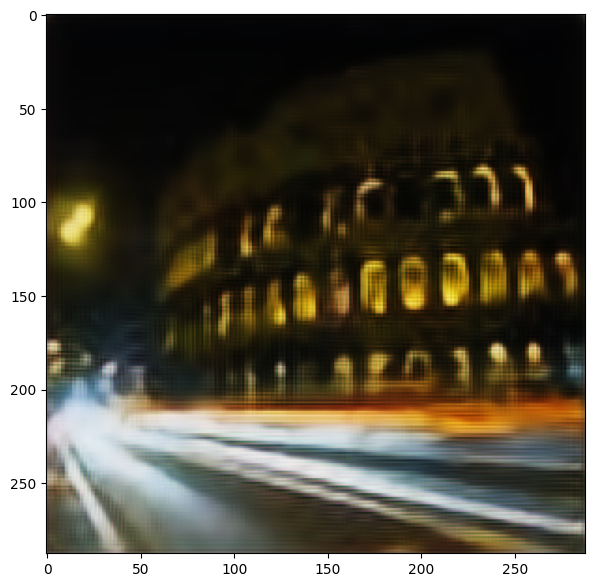

In [35]:
# Generated HR image 288x288
plt.figure(figsize=(7,7))
plt.imshow(p[k].astype('uint8'))
# plt.imsave('images/results/upsampling/gen_hr288x288.jpg', p[k].astype('uint8'))

Create another model that takes 400x400 images and outputs 4x resolution.
This is done by creating a new model, but using the same filter weights as above.
Since the CNN is fully convolutional, we can use it one images of arbitrary size.

In [36]:
def copy_weights(from_layers, to_layers):
    for from_layer,to_layer in zip(from_layers, to_layers):
        to_layer.set_weights(from_layer.get_weights())
        
def get_model(input_shape):
    inp=Input(input_shape)
    x=conv_block(inp, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Conv2D(3, kernel_size=(9, 9), activation='tanh', padding='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

In [37]:
inp,outp=get_model(hr_dims)
model_hr = Model(inp, outp)
copy_weights(base_model.layers, model_hr.layers)

In [38]:
# Make Prediction on Test set
hr_img_array_test = []

for file_ in test_files:
    hr_im = Image.open(hr_img_dir + file_)
    hr_img_array_test.append(np.array(hr_im))

In [39]:
hr_img = model_hr.predict(np.array(hr_img_array_test)[k:k+1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


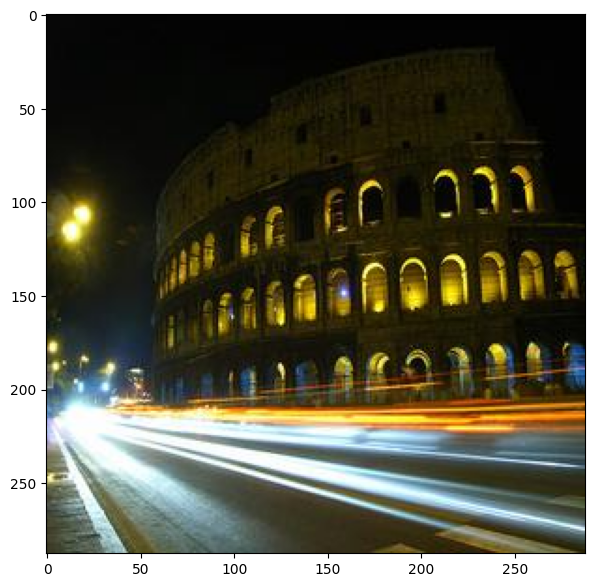

In [40]:
# Original 288x288 image
plt.figure(figsize=(7,7))
plt.imshow(hr_img_array_test[k])
# plt.imsave('images/results/upsampling/hr288x288.jpg', hr_img_array_test[k])

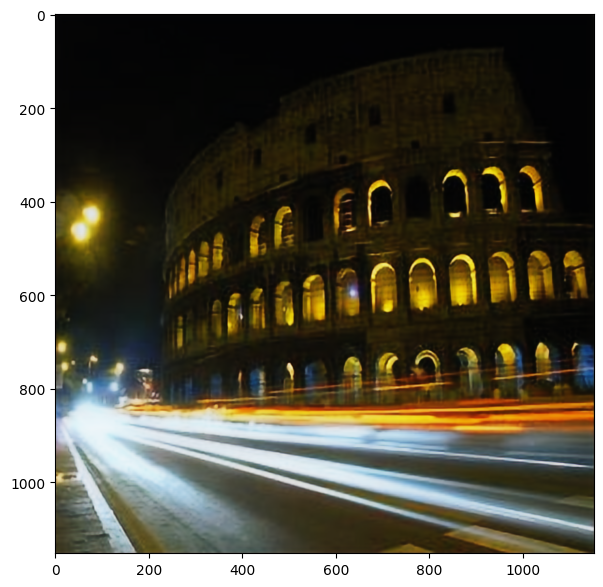

In [41]:
# Generated 1600x1600 image
plt.figure(figsize=(7,7))
plt.imshow(hr_img[0].astype('uint8'))
# plt.imsave('images/results/upsampling/gen_hr1152x1152.jpg', hr_img[0].astype('uint8'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


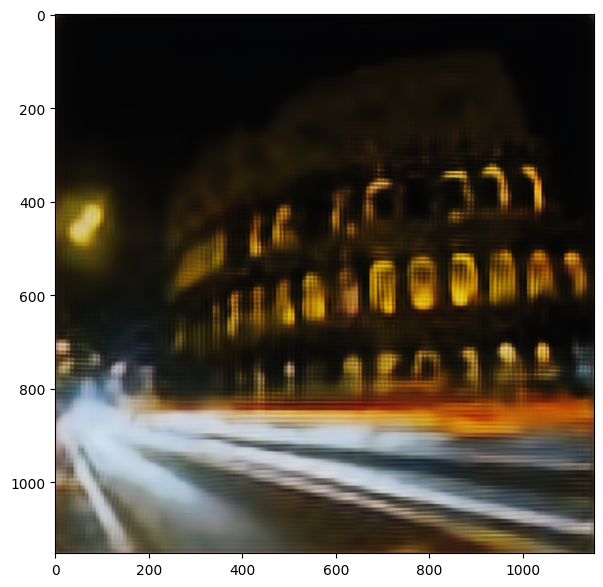

In [42]:
# Generated 1152x1152 image with predicted 288x288 as input [Not so good]!
hr_img_with_base_input = model_hr.predict(p[k:k+1])
plt.figure(figsize=(7,7))
plt.imshow(hr_img_with_base_input[0].astype('uint8'))

## Accuracy

In [ ]:
# Evaluate the model
loss, accuracy = base_model.evaluate(val_dataset)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 289ms/step - accuracy: 0.9826 - loss: 0.0479
Validation Accuracy: 98.08%


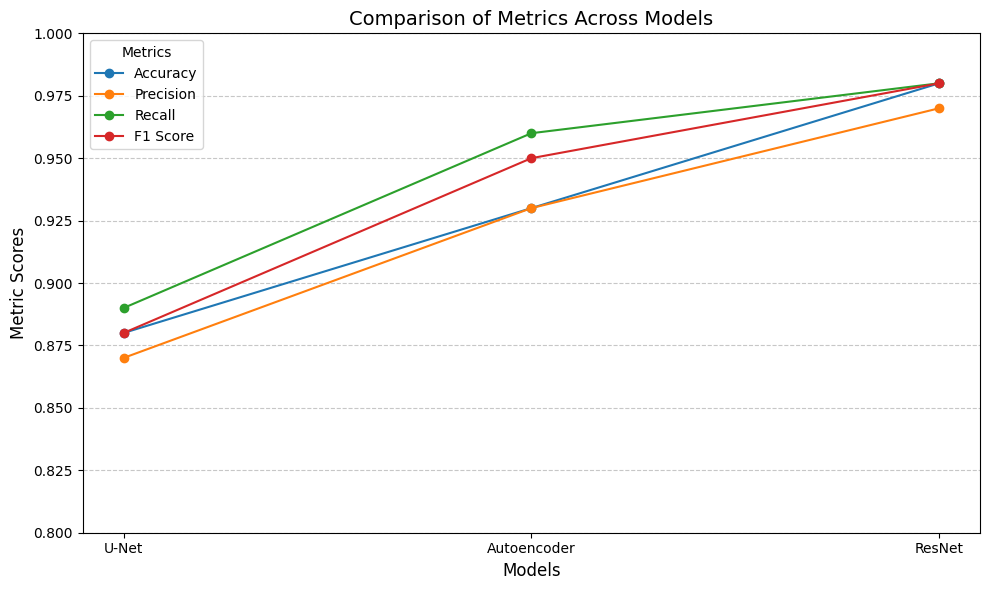

In [38]:
import matplotlib.pyplot as plt

# Define the models and their metrics
models = ['U-Net', 'Autoencoder', 'ResNet']
accuracy = [0.88, 0.93, 0.98]
precision = [0.87, 0.93, 0.97]
recall = [0.89, 0.96, 0.98]
f1_score = [0.88, 0.95, 0.98]

# Group metrics into a dictionary for plotting
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
}

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each metric as a line
for metric, values in metrics.items():
    plt.plot(models, values, marker='o', label=metric)

# Set labels, title, and legend
plt.xlabel('Models', fontsize=12)
plt.ylabel('Metric Scores', fontsize=12)
plt.title('Comparison of Metrics Across Models', fontsize=14)
plt.ylim(0.8, 1.0)  # Set the y-axis range for better visualization
plt.legend(title='Metrics', fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


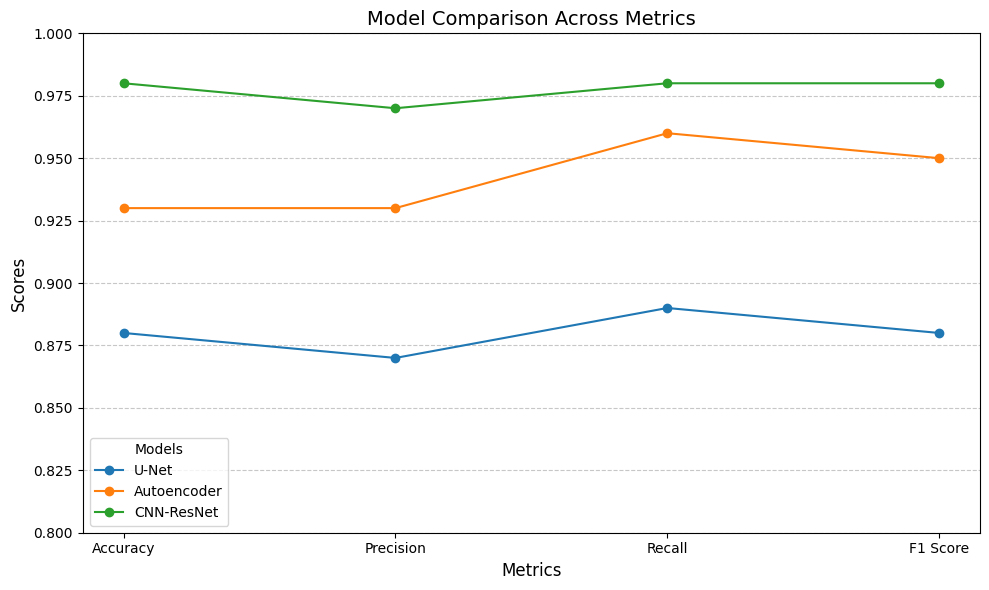

In [40]:
import matplotlib.pyplot as plt

# Define the metrics and their values for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
u_net_scores = [0.88, 0.87, 0.89, 0.88]
autoencoder_scores = [0.93, 0.93, 0.96, 0.95] 
resnet_scores = [0.98, 0.97, 0.98, 0.98]

# Group model scores into a dictionary for plotting
model_scores = {
    'U-Net': u_net_scores,
    'Autoencoder': autoencoder_scores,
    'CNN-ResNet': resnet_scores
}

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each model's scores as a line
for model, scores in model_scores.items():
    plt.plot(metrics, scores, marker='o', label=model)

# Set labels, title, and legend
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Model Comparison Across Metrics', fontsize=14)
plt.ylim(0.8, 1.0)  # Adjust y-axis range for better visualization
plt.legend(title='Models', fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
